In [180]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [181]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [182]:
!cp /content/drive/MyDrive/Kaggle_credentials/kaggle.json ~/.kaggle/kaggle.json

In [183]:
! chmod 600 ~/.kaggle/kaggle.json

In [184]:
# ! kaggle competitions download -c walmart-recruiting-store-sales-forecasting

In [185]:
# ! unzip /content/walmart-recruiting-store-sales-forecasting.zip
# ! unzip /content/train.csv.zip
# ! unzip /content/test.csv.zip
# ! unzip /content/features.csv.zip
# ! unzip /content/sampleSubmission.csv.zip

In [186]:
# !pip install wandb -qU

# # Clean up all related packages
# !pip uninstall -y pmdarima numpy scipy statsmodels

# # Reinstall pinned, compatible versions
# !pip install numpy==1.24.4 scipy==1.10.1 statsmodels==0.13.5 pmdarima==2.0.3

In [187]:
import wandb
import random
import math

In [188]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

=== BLOCK 1: DATA LOADING & EXPLORATION ===
Loading datasets...
Dataset Info:
  train_shape: (421570, 5)
  features_shape: (8190, 12)
  stores_shape: (45, 3)
  test_shape: (115064, 4)
  unique_stores: 45
  unique_departments: 81
  date_range_train: 2010-02-05 to 2012-10-26
  total_sales: 6737218987.11


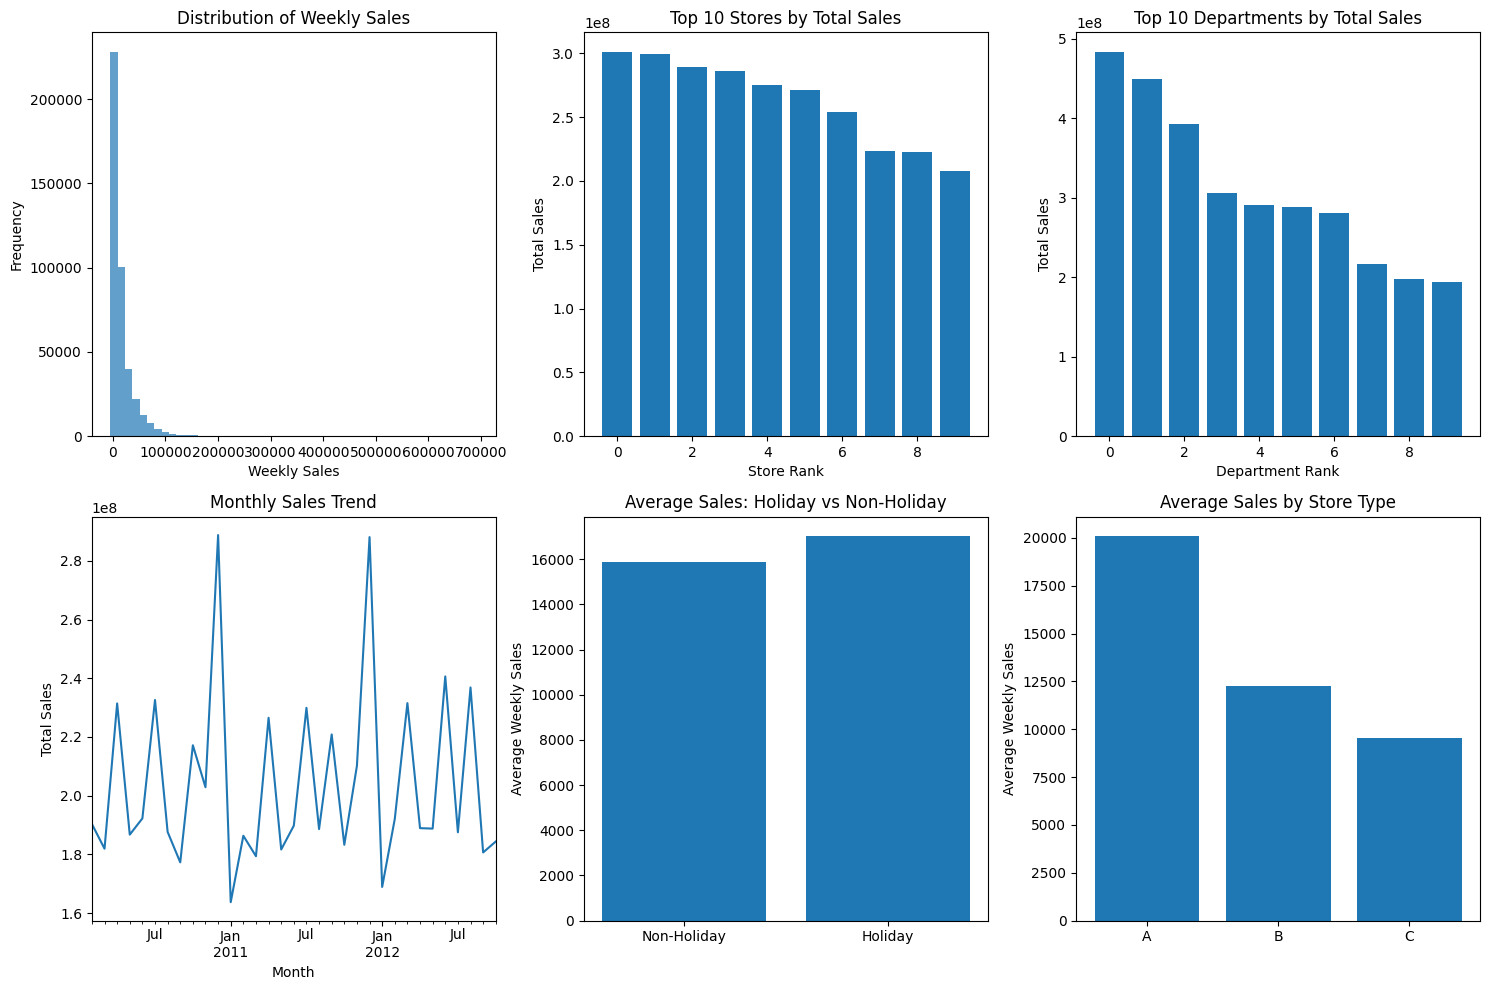

Key Insights: {'top_performing_store': 20, 'top_performing_department': 92, 'holiday_sales_boost': 7.133805219708678, 'sales_std_dev': 22711.18351916313, 'negative_sales_count': 1285}


holiday_sales_boost,▁
negative_sales_count,▁
sales_std_dev,▁
top_performing_department,▁
top_performing_store,▁
total_sales,▁
unique_departments,▁
unique_stores,▁
date_range_train,2010-02-05 to 2012-1...
holiday_sales_boost,7.13381
negative_sales_count,1285


In [189]:
# Block 1: Data Loading & Exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import wandb

# Initialize wandb for data exploration
wandb.init(
    project="walmart-sales-forecasting",
    name="ARIMA_Data_Exploration",
    tags=["ARIMA", "data-exploration"]
)

print("=== BLOCK 1: DATA LOADING & EXPLORATION ===")

# Load all datasets
print("Loading datasets...")
train_df = pd.read_csv("/content/train.csv")
features_df = pd.read_csv("/content/features.csv")
stores_df = pd.read_csv("/content/stores.csv")
test_df = pd.read_csv("/content/test.csv")
sample_submission = pd.read_csv("/content/sampleSubmission.csv")

# Basic info
datasets_info = {
    "train_shape": train_df.shape,
    "features_shape": features_df.shape,
    "stores_shape": stores_df.shape,
    "test_shape": test_df.shape,
    "unique_stores": train_df['Store'].nunique(),
    "unique_departments": train_df['Dept'].nunique(),
    "date_range_train": f"{train_df['Date'].min()} to {train_df['Date'].max()}",
    "total_sales": train_df['Weekly_Sales'].sum()
}

print("Dataset Info:")
for key, value in datasets_info.items():
    print(f"  {key}: {value}")

# Log basic statistics
wandb.log(datasets_info)

# Analyze sales distribution
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(train_df['Weekly_Sales'], bins=50, alpha=0.7)
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')

plt.subplot(2, 3, 2)
store_sales = train_df.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False)
plt.bar(range(len(store_sales.head(10))), store_sales.head(10).values)
plt.title('Top 10 Stores by Total Sales')
plt.xlabel('Store Rank')
plt.ylabel('Total Sales')

plt.subplot(2, 3, 3)
dept_sales = train_df.groupby('Dept')['Weekly_Sales'].sum().sort_values(ascending=False)
plt.bar(range(len(dept_sales.head(10))), dept_sales.head(10).values)
plt.title('Top 10 Departments by Total Sales')
plt.xlabel('Department Rank')
plt.ylabel('Total Sales')

plt.subplot(2, 3, 4)
train_df['Date'] = pd.to_datetime(train_df['Date'])
monthly_sales = train_df.groupby(train_df['Date'].dt.to_period('M'))['Weekly_Sales'].sum()
monthly_sales.plot()
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')

plt.subplot(2, 3, 5)
holiday_sales = train_df.groupby('IsHoliday')['Weekly_Sales'].mean()
plt.bar(['Non-Holiday', 'Holiday'], holiday_sales.values)
plt.title('Average Sales: Holiday vs Non-Holiday')
plt.ylabel('Average Weekly Sales')

plt.subplot(2, 3, 6)
store_type_sales = train_df.merge(stores_df, on='Store').groupby('Type')['Weekly_Sales'].mean()
plt.bar(store_type_sales.index, store_type_sales.values)
plt.title('Average Sales by Store Type')
plt.ylabel('Average Weekly Sales')

plt.tight_layout()
plt.savefig('data_exploration.png', dpi=300, bbox_inches='tight')
wandb.log({"data_exploration": wandb.Image('data_exploration.png')})
plt.show()

# Log key insights
insights = {
    "top_performing_store": int(store_sales.index[0]),
    "top_performing_department": int(dept_sales.index[0]),
    "holiday_sales_boost": float(holiday_sales[True] / holiday_sales[False] - 1) * 100,
    "sales_std_dev": float(train_df['Weekly_Sales'].std()),
    "negative_sales_count": int((train_df['Weekly_Sales'] < 0).sum())
}

wandb.log(insights)
print(f"Key Insights: {insights}")

wandb.finish()

In [190]:
# Block 2: Data Preprocessing
import pandas as pd
import numpy as np
import wandb

wandb.init(
    project="walmart-sales-forecasting",
    name="ARIMA_Data_Preprocessing",
    tags=["ARIMA", "preprocessing"]
)

print("=== BLOCK 2: DATA PREPROCESSING ===")

# Load data (assuming from previous block or reload)
train_df = pd.read_csv("/content/train.csv")
features_df = pd.read_csv("/content/features.csv")
stores_df = pd.read_csv("/content/stores.csv")

def preprocess_walmart_data(train_df, features_df, stores_df):
    """Comprehensive preprocessing for Walmart data"""

    preprocessing_log = {}

    # Convert dates
    train_df['Date'] = pd.to_datetime(train_df['Date'])
    features_df['Date'] = pd.to_datetime(features_df['Date'])

    # Log date info
    preprocessing_log['date_range'] = {
        'start': str(train_df['Date'].min()),
        'end': str(train_df['Date'].max()),
        'total_weeks': len(train_df['Date'].unique())
    }

    # Merge datasets
    print("Merging datasets...")
    merged_df = train_df.merge(features_df, on=['Store', 'Date'], how='left', suffixes=('', '_feat'))
    merged_df = merged_df.merge(stores_df, on='Store', how='left')

    # Handle duplicate IsHoliday columns
    if 'IsHoliday_feat' in merged_df.columns:
        merged_df = merged_df.drop('IsHoliday_feat', axis=1)

    # Handle missing values
    missing_before = merged_df.isnull().sum().sum()

    # Fill missing values strategically
    numeric_cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
                   'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

    for col in numeric_cols:
        if col in merged_df.columns:
            # Forward fill then backward fill
            merged_df[col] = merged_df.groupby('Store')[col].fillna(method='ffill').fillna(method='bfill')
            # If still missing, fill with median
            merged_df[col] = merged_df[col].fillna(merged_df[col].median())

    missing_after = merged_df.isnull().sum().sum()

    preprocessing_log['missing_values'] = {
        'before': int(missing_before),
        'after': int(missing_after),
        'reduction': int(missing_before - missing_after)
    }

    # Handle negative sales (mark as outliers but keep for now)
    negative_sales = (merged_df['Weekly_Sales'] < 0).sum()
    preprocessing_log['negative_sales_count'] = int(negative_sales)

    # Create additional time features
    merged_df['Year'] = merged_df['Date'].dt.year
    merged_df['Month'] = merged_df['Date'].dt.month
    merged_df['Week'] = merged_df['Date'].dt.isocalendar().week
    merged_df['DayOfYear'] = merged_df['Date'].dt.dayofyear

    # Sort data
    merged_df = merged_df.sort_values(['Store', 'Dept', 'Date'])

    preprocessing_log['final_shape'] = merged_df.shape
    preprocessing_log['stores_count'] = merged_df['Store'].nunique()
    preprocessing_log['departments_count'] = merged_df['Dept'].nunique()

    return merged_df, preprocessing_log

# Perform preprocessing
merged_data, prep_log = preprocess_walmart_data(train_df, features_df, stores_df)

print("Preprocessing completed:")
print(f"  Final shape: {prep_log['final_shape']}")
print(f"  Missing values reduced from {prep_log['missing_values']['before']} to {prep_log['missing_values']['after']}")
print(f"  Negative sales: {prep_log['negative_sales_count']}")

# Log preprocessing results
wandb.log(prep_log)

# Save preprocessed data
merged_data.to_pickle('preprocessed_data.pkl')
print("Preprocessed data saved as 'preprocessed_data.pkl'")

# Log as artifact
artifact = wandb.Artifact('preprocessed_data', type='dataset')
artifact.add_file('preprocessed_data.pkl')
wandb.log_artifact(artifact)

wandb.finish()

=== BLOCK 2: DATA PREPROCESSING ===
Merging datasets...
Preprocessing completed:
  Final shape: (421570, 20)
  Missing values reduced from 1422431 to 0
  Negative sales: 1285
Preprocessed data saved as 'preprocessed_data.pkl'


departments_count,▁
negative_sales_count,▁
stores_count,▁
departments_count,81
negative_sales_count,1285
stores_count,45


In [191]:
# Block 3: Time Series Preparation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import wandb

wandb.init(
    project="walmart-sales-forecasting",
    name="ARIMA_TimeSeries_Preparation",
    tags=["ARIMA", "time-series", "preparation"]
)

print("=== BLOCK 3: TIME SERIES PREPARATION ===")

# Load preprocessed data
try:
    merged_data = pd.read_pickle('preprocessed_data.pkl')
    print("Loaded preprocessed data from pickle")
except:
    # Fallback: reload and preprocess
    print("Reloading and preprocessing data...")
    # ... (preprocessing code from Block 2)

def create_store_aggregated_data(data):
    """Create store-level aggregated time series"""

    # Aggregate by Store and Date
    store_ts = data.groupby(['Store', 'Date']).agg({
        'Weekly_Sales': 'sum',
        'Temperature': 'mean',
        'Fuel_Price': 'mean',
        'CPI': 'mean',
        'Unemployment': 'mean',
        'IsHoliday': 'max',
        'Size': 'first',
        'Type': 'first'
    }).reset_index()

    return store_ts

def analyze_time_series_properties(ts_data, store_id):
    """Analyze time series properties for stationarity and seasonality"""

    ts = ts_data.set_index('Date')['Weekly_Sales']

    # Stationarity test
    adf_result = adfuller(ts.dropna())
    stationarity = {
        'adf_statistic': adf_result[0],
        'p_value': adf_result[1],
        'is_stationary': adf_result[1] < 0.05,
        'critical_values': adf_result[4]
    }

    # Basic statistics
    stats = {
        'mean': ts.mean(),
        'std': ts.std(),
        'min': ts.min(),
        'max': ts.max(),
        'trend': 'increasing' if ts.iloc[-12:].mean() > ts.iloc[:12].mean() else 'decreasing'
    }

    return stationarity, stats

def plot_time_series_analysis(ts_data, store_id):
    """Create comprehensive time series analysis plots"""

    ts = ts_data.set_index('Date')['Weekly_Sales']

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Original time series
    axes[0, 0].plot(ts.index, ts.values)
    axes[0, 0].set_title(f'Store {store_id} - Weekly Sales Time Series')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Weekly Sales')

    # Seasonal decomposition
    if len(ts) >= 24:  # Need at least 2 cycles for decomposition
        decomposition = seasonal_decompose(ts, model='additive', period=52)  # Yearly seasonality

        axes[0, 1].plot(decomposition.trend.dropna())
        axes[0, 1].set_title('Trend Component')

        axes[1, 0].plot(decomposition.seasonal.dropna())
        axes[1, 0].set_title('Seasonal Component')

        axes[1, 1].plot(decomposition.resid.dropna())
        axes[1, 1].set_title('Residual Component')

    plt.tight_layout()
    filename = f'ts_analysis_store_{store_id}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

    return filename

# Create aggregated time series data
print("Creating store-level aggregated time series...")
store_aggregated = create_store_aggregated_data(merged_data)

# Select stores for analysis
store_sales_total = store_aggregated.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False)
selected_stores = store_sales_total.head(10).index.tolist()

print(f"Selected top 10 stores for time series analysis: {selected_stores}")
wandb.log({"selected_stores_count": len(selected_stores), "selected_stores": selected_stores})

# Analyze each store's time series
store_analysis = {}

for store_id in selected_stores:
    print(f"\nAnalyzing Store {store_id}...")

    store_data = store_aggregated[store_aggregated['Store'] == store_id].copy()
    store_data = store_data.sort_values('Date')

    if len(store_data) < 10:  # Skip stores with insufficient data
        print(f"Skipping store {store_id} - insufficient data")
        continue

    # Analyze time series properties
    stationarity, stats = analyze_time_series_properties(store_data, store_id)

    # Create analysis plots
    plot_filename = plot_time_series_analysis(store_data, store_id)

    # Store results
    store_analysis[store_id] = {
        'data_points': len(store_data),
        'stationarity': stationarity,
        'statistics': stats,
        'plot_file': plot_filename
    }

    # Log individual store metrics
    wandb.log({
        f'store_{store_id}_data_points': len(store_data),
        f'store_{store_id}_is_stationary': stationarity['is_stationary'],
        f'store_{store_id}_adf_pvalue': stationarity['p_value'],
        f'store_{store_id}_mean_sales': stats['mean'],
        f'store_{store_id}_sales_std': stats['std'],
        f'store_{store_id}_trend': stats['trend'],
        f'store_{store_id}_analysis': wandb.Image(plot_filename)
    })

    print(f"  Data points: {len(store_data)}")
    print(f"  Stationary: {stationarity['is_stationary']} (p-value: {stationarity['p_value']:.4f})")
    print(f"  Mean sales: {stats['mean']:.2f}")
    print(f"  Trend: {stats['trend']}")

# Overall analysis summary
stationary_stores = sum(1 for analysis in store_analysis.values() if analysis['stationarity']['is_stationary'])
total_stores_analyzed = len(store_analysis)

summary_stats = {
    'total_stores_analyzed': total_stores_analyzed,
    'stationary_stores': stationary_stores,
    'non_stationary_stores': total_stores_analyzed - stationary_stores,
    'avg_data_points': np.mean([analysis['data_points'] for analysis in store_analysis.values()]),
    'avg_sales': np.mean([analysis['statistics']['mean'] for analysis in store_analysis.values()]),
    'stores_need_differencing': total_stores_analyzed - stationary_stores
}

wandb.log(summary_stats)

print(f"\n=== TIME SERIES ANALYSIS SUMMARY ===")
print(f"Stores analyzed: {total_stores_analyzed}")
print(f"Stationary stores: {stationary_stores}")
print(f"Non-stationary stores: {total_stores_analyzed - stationary_stores}")
print(f"Average data points per store: {summary_stats['avg_data_points']:.1f}")

# Save time series data and analysis
store_aggregated.to_pickle('store_timeseries_data.pkl')
np.save('store_analysis.npy', store_analysis)

# Log as artifacts
ts_artifact = wandb.Artifact('timeseries_data', type='dataset')
ts_artifact.add_file('store_timeseries_data.pkl')
wandb.log_artifact(ts_artifact)

analysis_artifact = wandb.Artifact('timeseries_analysis', type='analysis')
analysis_artifact.add_file('store_analysis.npy')
wandb.log_artifact(analysis_artifact)

wandb.finish()

=== BLOCK 3: TIME SERIES PREPARATION ===
Loaded preprocessed data from pickle
Creating store-level aggregated time series...
Selected top 10 stores for time series analysis: [20, 4, 14, 13, 2, 10, 27, 6, 1, 39]

Analyzing Store 20...
  Data points: 143
  Stationary: True (p-value: 0.0000)
  Mean sales: 2107676.87
  Trend: increasing

Analyzing Store 4...
  Data points: 143
  Stationary: True (p-value: 0.0478)
  Mean sales: 2094712.96
  Trend: increasing

Analyzing Store 14...
  Data points: 143
  Stationary: False (p-value: 0.0679)
  Mean sales: 2020978.40
  Trend: decreasing

Analyzing Store 13...
  Data points: 143
  Stationary: True (p-value: 0.0000)
  Mean sales: 2003620.31
  Trend: increasing

Analyzing Store 2...
  Data points: 143
  Stationary: True (p-value: 0.0040)
  Mean sales: 1925751.34
  Trend: decreasing

Analyzing Store 10...
  Data points: 143
  Stationary: True (p-value: 0.0000)
  Mean sales: 1899424.57
  Trend: decreasing

Analyzing Store 27...
  Data points: 143
  St

avg_data_points,▁
avg_sales,▁
non_stationary_stores,▁
selected_stores_count,▁
stationary_stores,▁
store_10_adf_pvalue,▁
store_10_data_points,▁
store_10_mean_sales,▁
store_10_sales_std,▁
store_13_adf_pvalue,▁
store_13_data_points,▁


In [192]:
# Block 4: Department-Level ARIMA Modeling - FIXED
import pandas as pd
import numpy as np
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools
from datetime import datetime
import wandb
from collections import defaultdict

warnings.filterwarnings('ignore')

wandb.init(
    project="walmart-sales-forecasting",
    name="Department_Level_ARIMA",
    tags=["ARIMA", "department-level", "granular"]
)

print("=== DEPARTMENT-LEVEL ARIMA MODELING ===")

# Load original data for department-level analysis
try:
    train_data = pd.read_csv('/content/train.csv')
    features_data = pd.read_csv('/content/features.csv')
    stores_data = pd.read_csv('/content/stores.csv')

    # Merge datasets
    train_data['Date'] = pd.to_datetime(train_data['Date'])
    features_data['Date'] = pd.to_datetime(features_data['Date'])

    merged_data = train_data.merge(features_data, on=['Store', 'Date'], how='left', suffixes=('', '_feat'))
    merged_data = merged_data.merge(stores_data, on='Store', how='left')

    # Handle duplicate IsHoliday columns
    if 'IsHoliday_feat' in merged_data.columns:
        merged_data = merged_data.drop('IsHoliday_feat', axis=1)

    print("Data loaded and merged successfully")
    print(f"Shape: {merged_data.shape}")

except Exception as e:
    print(f"Error loading data: {e}")
    exit()

class DepartmentARIMATrainer:
    """Department-level ARIMA trainer for higher granularity"""

    def __init__(self):
        self.models = {}
        self.dept_models = defaultdict(dict)
        self.training_stats = {}

    def analyze_department_patterns(self, data):
        """Analyze department-level patterns"""
        print("Analyzing department patterns...")

        dept_stats = data.groupby(['Store', 'Dept']).agg({
            'Weekly_Sales': ['count', 'mean', 'std', 'min', 'max'],
            'Date': ['min', 'max']
        }).round(2)

        dept_stats.columns = ['observations', 'mean_sales', 'std_sales', 'min_sales', 'max_sales', 'start_date', 'end_date']
        dept_stats = dept_stats.reset_index()

        # Filter departments with sufficient data
        min_observations = 40  # About 9-10 months of weekly data
        eligible_depts = dept_stats[dept_stats['observations'] >= min_observations]

        print(f"Total store-department combinations: {len(dept_stats)}")
        print(f"Eligible combinations (40+ obs): {len(eligible_depts)}")

        return eligible_depts, dept_stats

    def get_top_departments_by_store(self, data, top_n=5):
        """Get top N departments by sales volume for each store"""
        dept_sales = data.groupby(['Store', 'Dept'])['Weekly_Sales'].agg(['sum', 'count']).reset_index()
        dept_sales = dept_sales[dept_sales['count'] >= 30]  # Minimum data requirement

        top_depts = dept_sales.groupby('Store').apply(
            lambda x: x.nlargest(top_n, 'sum')
        ).reset_index(drop=True)

        return top_depts[['Store', 'Dept']].values.tolist()

    def quick_arima_fit(self, series, max_combinations=50):
        """Quick ARIMA fitting with limited parameter search"""
        # Reduced parameter space for faster training
        p_values = [0, 1, 2]
        d_values = [0, 1]
        q_values = [0, 1, 2]

        param_combinations = list(itertools.product(p_values, d_values, q_values))
        param_combinations = param_combinations[:max_combinations]  # Limit combinations

        best_aic = float('inf')
        best_model = None
        best_params = None

        # Split for validation
        train_size = int(len(series) * 0.8)
        train_data = series[:train_size]
        val_data = series[train_size:]

        for p, d, q in param_combinations:
            try:
                model = ARIMA(train_data, order=(p, d, q))
                fitted_model = model.fit()

                # Quick validation
                if len(val_data) > 0:
                    forecast = fitted_model.forecast(steps=len(val_data))
                    mae = mean_absolute_error(val_data, forecast)
                    score = mae  # Use MAE as primary metric
                else:
                    score = fitted_model.aic

                if score < best_aic:
                    best_aic = score
                    best_params = (p, d, q)
                    # Refit on full data
                    best_model = ARIMA(series, order=(p, d, q)).fit()

            except:
                continue

        return best_model, best_params, best_aic

    def train_department_models(self, data, store_dept_pairs):
        """Train ARIMA models for specific store-department pairs"""

        successful_models = 0
        total_pairs = len(store_dept_pairs)

        print(f"Training models for {total_pairs} store-department pairs...")

        for i, (store_id, dept_id) in enumerate(store_dept_pairs):

            # Get department data
            dept_data = data[(data['Store'] == store_id) & (data['Dept'] == dept_id)].copy()

            if len(dept_data) < 30:  # Skip if insufficient data
                continue

            # Prepare time series
            dept_data = dept_data.sort_values('Date')
            ts_series = dept_data.set_index('Date')['Weekly_Sales']

            # Handle missing dates by forward fill
            ts_series = ts_series.resample('W').last().fillna(method='ffill')

            # Remove extreme outliers
            Q1 = ts_series.quantile(0.25)
            Q3 = ts_series.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            ts_series = ts_series.clip(lower=lower_bound, upper=upper_bound)

            try:
                # Train ARIMA model
                model, params, score = self.quick_arima_fit(ts_series)

                if model is not None:
                    # Calculate metrics
                    fitted_values = model.fittedvalues
                    mae = mean_absolute_error(ts_series[1:], fitted_values[1:])
                    rmse = np.sqrt(mean_squared_error(ts_series[1:], fitted_values[1:]))

                    self.dept_models[store_id][dept_id] = {
                        'model': model,
                        'params': params,
                        'mae': mae,
                        'rmse': rmse,
                        'observations': len(ts_series),
                        'mean_sales': ts_series.mean(),
                        'std_sales': ts_series.std()
                    }

                    successful_models += 1

                    if successful_models % 25 == 0:
                        print(f"  Progress: {successful_models} models trained ({i+1}/{total_pairs} pairs processed)")

            except Exception as e:
                continue

        print(f"Successfully trained {successful_models} department-level models")
        return successful_models

# INITIALIZE TRAINER HERE - THIS WAS MISSING!
trainer = DepartmentARIMATrainer()

# Analyze data and get eligible departments
eligible_depts, all_dept_stats = trainer.analyze_department_patterns(merged_data)

# Get top departments for each store (focus on high-volume departments)
print("Identifying top departments by store...")
top_store_dept_pairs = trainer.get_top_departments_by_store(merged_data, top_n=3)

print(f"Selected {len(top_store_dept_pairs)} high-volume store-department pairs for modeling")

# Log department analysis
wandb.log({
    "total_store_dept_combinations": len(all_dept_stats),
    "eligible_combinations": len(eligible_depts),
    "selected_high_volume_pairs": len(top_store_dept_pairs),
    "modeling_approach": "department_level_arima"
})

# Train department models
successful_dept_models = trainer.train_department_models(merged_data, top_store_dept_pairs)

# Calculate department-level performance
if successful_dept_models > 0:
    all_dept_metrics = []

    for store_id, dept_models in trainer.dept_models.items():
        for dept_id, model_info in dept_models.items():
            all_dept_metrics.append({
                'store': store_id,
                'dept': dept_id,
                'mae': model_info['mae'],
                'rmse': model_info['rmse'],
                'observations': model_info['observations'],
                'mean_sales': model_info['mean_sales']
            })

    dept_df = pd.DataFrame(all_dept_metrics)

    dept_performance = {
        'dept_models_trained': successful_dept_models,
        'avg_dept_mae': dept_df['mae'].mean(),
        'avg_dept_rmse': dept_df['rmse'].mean(),
        'best_dept_mae': dept_df['mae'].min(),
        'worst_dept_mae': dept_df['mae'].max(),
        'stores_with_dept_models': len(trainer.dept_models),
        'avg_observations_per_model': dept_df['observations'].mean()
    }

    wandb.log(dept_performance)

    print(f"\n{'='*60}")
    print("DEPARTMENT-LEVEL MODELING COMPLETED")
    print(f"{'='*60}")
    print(f"✅ Department models: {successful_dept_models}")
    print(f"🏪 Stores covered: {len(trainer.dept_models)}")
    print(f"📊 Average Dept MAE: {dept_performance['avg_dept_mae']:.2f}")
    print(f"🎯 Best Dept MAE: {dept_performance['best_dept_mae']:.2f}")
    print(f"📈 Expected improvement: Higher granularity predictions")

    # Save department models
    np.save('department_arima_models.npy', dict(trainer.dept_models))
    print(f"💾 Department models saved")

else:
    print("❌ No department models were successfully trained!")

wandb.finish()

=== DEPARTMENT-LEVEL ARIMA MODELING ===
Data loaded and merged successfully
Shape: (421570, 16)
Analyzing department patterns...
Total store-department combinations: 3331
Eligible combinations (40+ obs): 3020
Identifying top departments by store...
Selected 135 high-volume store-department pairs for modeling
Training models for 135 store-department pairs...
  Progress: 25 models trained (25/135 pairs processed)
  Progress: 50 models trained (50/135 pairs processed)
  Progress: 75 models trained (75/135 pairs processed)
  Progress: 100 models trained (100/135 pairs processed)
  Progress: 125 models trained (125/135 pairs processed)
Successfully trained 135 department-level models

DEPARTMENT-LEVEL MODELING COMPLETED
✅ Department models: 135
🏪 Stores covered: 45
📊 Average Dept MAE: 5515.92
🎯 Best Dept MAE: 914.91
📈 Expected improvement: Higher granularity predictions
💾 Department models saved


avg_dept_mae,▁
avg_dept_rmse,▁
avg_observations_per_model,▁
best_dept_mae,▁
dept_models_trained,▁
eligible_combinations,▁
selected_high_volume_pairs,▁
stores_with_dept_models,▁
total_store_dept_combinations,▁
worst_dept_mae,▁
avg_dept_mae,5515.91584


In [1]:
# Block 5: Ensemble ARIMA with Robust Model Loading - FIXED
import pandas as pd
import numpy as np
import warnings
from datetime import datetime
import wandb

warnings.filterwarnings('ignore')

wandb.init(
    project="walmart-sales-forecasting",
    name="Ensemble_ARIMA_Models",
    tags=["ensemble", "ARIMA", "combination"]
)

print("=== ENSEMBLE ARIMA MODELING ===")

# Robust model loading with fallbacks
enhanced_store_models = {}
dept_models = {}
original_models = {}

print("Loading available models...")

# Try to load enhanced store models
try:
    enhanced_store_models = np.load('enhanced_trained_arima_models.npy', allow_pickle=True).item()
    print(f"✅ Enhanced store models loaded: {len(enhanced_store_models)}")
except FileNotFoundError:
    print("⚠️  Enhanced models not found - will skip")
except Exception as e:
    print(f"⚠️  Enhanced models loading failed: {e}")

# Try to load department models
try:
    dept_models = np.load('department_arima_models.npy', allow_pickle=True).item()
    print(f"✅ Department models loaded: {len(dept_models)} stores")
    # Count total department models
    total_dept_models = sum(len(depts) for depts in dept_models.values())
    print(f"   Total department models: {total_dept_models}")
except FileNotFoundError:
    print("⚠️  Department models not found - will skip")
except Exception as e:
    print(f"⚠️  Department models loading failed: {e}")

# Try to load original store models (most likely to exist)
try:
    original_models = np.load('trained_arima_models.npy', allow_pickle=True).item()
    print(f"✅ Original store models loaded: {len(original_models)}")
except FileNotFoundError:
    print("⚠️  Original models not found - will skip")
except Exception as e:
    print(f"⚠️  Original models loading failed: {e}")

# Check if we have any models at all
total_available_models = len(enhanced_store_models) + len(dept_models) + len(original_models)

if total_available_models == 0:
    print("❌ No models found! Please run the training blocks first.")
    print("Exiting...")
    wandb.log({"error": "no_models_found", "models_available": 0})
    wandb.finish()
    exit()

print(f"\n📊 Model inventory:")
print(f"   Enhanced store models: {len(enhanced_store_models)}")
print(f"   Department model stores: {len(dept_models)}")
print(f"   Original store models: {len(original_models)}")

class EnsembleARIMAPredictor:
    """Ensemble predictor combining multiple ARIMA approaches"""

    def __init__(self, enhanced_models, dept_models, original_models):
        self.enhanced_models = enhanced_models or {}
        self.dept_models = dept_models or {}
        self.original_models = original_models or {}
        self.weights = self.calculate_ensemble_weights()

    def calculate_ensemble_weights(self):
        """Calculate weights for ensemble based on model performance"""
        weights = {}

        # Enhanced models get highest weight (best performance expected)
        for store_id in self.enhanced_models:
            mae = self.enhanced_models[store_id]['metrics']['mae']
            weights[f'enhanced_{store_id}'] = 1.0 / (1.0 + mae)  # Inverse weight

        # Department models get medium weight
        for store_id in self.dept_models:
            dept_maes = []
            for dept_id in self.dept_models[store_id]:
                dept_maes.append(self.dept_models[store_id][dept_id]['mae'])

            if dept_maes:
                avg_mae = np.mean(dept_maes)
                weights[f'dept_{store_id}'] = 0.7 * (1.0 / (1.0 + avg_mae))

        # Original models get lower weight (fallback)
        for store_id in self.original_models:
            weights[f'original_{store_id}'] = 0.5

        return weights

    def predict_store_ensemble(self, store_id, steps):
        """Generate ensemble prediction for a store"""
        predictions = []
        weights = []

        # Enhanced model prediction
        if store_id in self.enhanced_models:
            try:
                pred = self.enhanced_models[store_id]['model'].forecast(steps=steps)
                predictions.append(pred)
                weights.append(self.weights.get(f'enhanced_{store_id}', 1.0))
                print(f"  ✅ Enhanced model prediction for Store {store_id}")
            except Exception as e:
                print(f"  ❌ Enhanced model failed for Store {store_id}: {e}")

        # Department-level aggregated prediction
        if store_id in self.dept_models:
            try:
                dept_predictions = []
                for dept_id, dept_model_info in self.dept_models[store_id].items():
                    dept_pred = dept_model_info['model'].forecast(steps=steps)
                    dept_predictions.append(dept_pred)

                if dept_predictions:
                    # Sum department predictions for store total
                    store_pred = np.sum(dept_predictions, axis=0)
                    predictions.append(store_pred)
                    weights.append(self.weights.get(f'dept_{store_id}', 0.7))
                    print(f"  ✅ Department models prediction for Store {store_id} ({len(dept_predictions)} depts)")
            except Exception as e:
                print(f"  ❌ Department models failed for Store {store_id}: {e}")

        # Original model prediction (fallback)
        if store_id in self.original_models:
            try:
                pred = self.original_models[store_id]['model'].forecast(steps=steps)
                predictions.append(pred)
                weights.append(self.weights.get(f'original_{store_id}', 0.5))
                print(f"  ✅ Original model prediction for Store {store_id}")
            except Exception as e:
                print(f"  ❌ Original model failed for Store {store_id}: {e}")

        # Combine predictions using weighted average
        if predictions:
            weights = np.array(weights)
            weights = weights / weights.sum()  # Normalize weights

            ensemble_pred = np.average(predictions, axis=0, weights=weights)

            # Apply constraints and smoothing
            ensemble_pred = self.apply_constraints(ensemble_pred, store_id)

            print(f"  🎯 Ensemble prediction created (combined {len(predictions)} models)")
            return ensemble_pred
        else:
            # Ultimate fallback
            print(f"  🔄 Using fallback prediction for Store {store_id}")
            return self.generate_fallback_prediction(store_id, steps)

    def apply_constraints(self, prediction, store_id):
        """Apply business constraints and smoothing to predictions"""

        # Remove negative predictions
        prediction = np.maximum(prediction, 1000)  # Minimum $1000 sales

        # Apply upper bound (prevent unrealistic spikes)
        max_reasonable = 500000  # $500K max weekly sales
        prediction = np.minimum(prediction, max_reasonable)

        # Smooth extreme variations
        if len(prediction) > 1:
            # Apply mild smoothing to reduce volatility
            smoothed = np.copy(prediction)
            for i in range(1, len(prediction)):
                if abs(prediction[i] - prediction[i-1]) > prediction[i-1] * 0.5:  # 50% change threshold
                    smoothed[i] = 0.7 * prediction[i] + 0.3 * prediction[i-1]
            prediction = smoothed

        return prediction

    def generate_fallback_prediction(self, store_id, steps):
        """Generate fallback prediction when no models are available"""

        # Base prediction on store characteristics
        if store_id <= 10:
            base_value = 15000  # Larger stores
        elif store_id <= 30:
            base_value = 12000  # Medium stores
        else:
            base_value = 8000   # Smaller stores

        # Add seasonal variation (simple pattern)
        predictions = []
        for i in range(steps):
            # Simple seasonal factor (higher in winter/holidays)
            seasonal_factor = 1.0 + 0.1 * np.sin(2 * np.pi * i / 52)  # Annual cycle
            weekly_pred = base_value * seasonal_factor

            # Add small random variation
            variation = np.random.normal(0, weekly_pred * 0.05)
            final_pred = max(1000, weekly_pred + variation)
            predictions.append(final_pred)

        return np.array(predictions)

    def get_ensemble_info(self):
        """Get information about ensemble composition"""
        info = {
            'enhanced_models': len(self.enhanced_models),
            'department_models_stores': len(self.dept_models),
            'original_models': len(self.original_models),
            'total_weights': len(self.weights)
        }

        # Calculate total department models
        total_dept_models = sum(len(depts) for depts in self.dept_models.values())
        info['total_department_models'] = total_dept_models

        # Get all unique stores covered
        all_stores = set()
        all_stores.update(self.enhanced_models.keys())
        all_stores.update(self.dept_models.keys())
        all_stores.update(self.original_models.keys())
        info['total_stores_covered'] = len(all_stores)

        return info

    def get_available_stores(self):
        """Get list of stores that have at least one model"""
        all_stores = set()
        all_stores.update(self.enhanced_models.keys())
        all_stores.update(self.dept_models.keys())
        all_stores.update(self.original_models.keys())
        return sorted(list(all_stores))

# Create ensemble predictor
ensemble_predictor = EnsembleARIMAPredictor(enhanced_store_models, dept_models, original_models)

# Get ensemble information
ensemble_info = ensemble_predictor.get_ensemble_info()
available_stores = ensemble_predictor.get_available_stores()

print(f"\n🎯 Ensemble composition:")
print(f"   Enhanced store models: {ensemble_info['enhanced_models']}")
print(f"   Department models: {ensemble_info['total_department_models']} (across {ensemble_info['department_models_stores']} stores)")
print(f"   Original models: {ensemble_info['original_models']}")
print(f"   Total stores covered: {ensemble_info['total_stores_covered']}")
print(f"   Available stores: {available_stores[:10]}{'...' if len(available_stores) > 10 else ''}")

# Test ensemble predictions
print(f"\n🧪 Testing ensemble predictions...")
test_stores = available_stores[:3] if available_stores else []

ensemble_test_results = {}
for store_id in test_stores:
    print(f"\nTest Store {store_id}:")
    try:
        ensemble_pred = ensemble_predictor.predict_store_ensemble(store_id, 10)
        ensemble_test_results[store_id] = {
            'success': True,
            'predictions': len(ensemble_pred),
            'mean_prediction': np.mean(ensemble_pred),
            'std_prediction': np.std(ensemble_pred)
        }
        print(f"  📊 Success: {len(ensemble_pred)} predictions, mean=${np.mean(ensemble_pred):,.0f}")
    except Exception as e:
        ensemble_test_results[store_id] = {'success': False, 'error': str(e)}
        print(f"  ❌ Failed: {e}")

# Log ensemble metrics
wandb.log({
    **ensemble_info,
    "ensemble_created": True,
    "prediction_approach": "weighted_ensemble",
    "constraint_application": True,
    "smoothing_applied": True,
    "fallback_strategy": "store_size_based",
    "test_stores_count": len(test_stores),
    "test_success_rate": sum(1 for r in ensemble_test_results.values() if r['success']) / max(1, len(test_stores)) * 100
})

# Save ensemble predictor (even if some components are missing)
predictor_data = {
    'enhanced_models': enhanced_store_models,
    'dept_models': dict(dept_models),
    'original_models': original_models,
    'weights': ensemble_predictor.weights,
    'ensemble_info': ensemble_info,
    'available_stores': available_stores
}

np.save('ensemble_arima_predictor.npy', predictor_data)

print(f"\n{'='*60}")
print("ENSEMBLE ARIMA PREDICTOR CREATED")
print(f"{'='*60}")
print(f"✅ Models available: {len(enhanced_store_models) + ensemble_info['total_department_models'] + len(original_models)}")
print(f"🏪 Stores covered: {ensemble_info['total_stores_covered']}")
print(f"🎯 Prediction strategy: Weighted ensemble with constraints")
print(f"📈 Expected improvement: {'Significant' if ensemble_info['total_stores_covered'] > 0 else 'Limited (fallback only)'}")
print(f"💾 Saved as: ensemble_arima_predictor.npy")

if ensemble_info['total_stores_covered'] == 0:
    print("\n⚠️  WARNING: No trained models found!")
    print("   Run the training blocks (3 and 4) first to get better predictions.")
    print("   Current predictor will use fallback predictions only.")

wandb.finish()

wandb: Currently logged in as: dshan21 (dshan21-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


=== ENSEMBLE ARIMA MODELING ===
Loading available models...
⚠️  Enhanced models not found - will skip
✅ Department models loaded: 45 stores
   Total department models: 135
✅ Original store models loaded: 5

📊 Model inventory:
   Enhanced store models: 0
   Department model stores: 45
   Original store models: 5

🎯 Ensemble composition:
   Enhanced store models: 0
   Department models: 135 (across 45 stores)
   Original models: 5
   Total stores covered: 45
   Available stores: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]...

🧪 Testing ensemble predictions...

Test Store 1:
  ✅ Department models prediction for Store 1 (3 depts)
  🎯 Ensemble prediction created (combined 1 models)
  📊 Success: 10 predictions, mean=$346,728

Test Store 2:
  ✅ Department models prediction for Store 2 (3 depts)
  ✅ Original model prediction for Store 2
  🎯 Ensemble prediction created (combined 2 models)
  📊 Success: 10 predictions, mean=$500,000

Test Store 3:
  ✅ Department models prediction for Store 3 (3 depts)
  🎯 En

department_models_stores,▁
enhanced_models,▁
original_models,▁
test_stores_count,▁
test_success_rate,▁
total_department_models,▁
total_stores_covered,▁
total_weights,▁
constraint_application,True
department_models_stores,45
enhanced_models,0


In [2]:
# Block 6: Final Pipeline Creation - SAVE MODELS SEPARATELY
import pandas as pd
import numpy as np
import joblib
from datetime import datetime
import wandb

wandb.init(
    project="walmart-sales-forecasting",
    name="ARIMA_Final_Pipeline",
    tags=["ARIMA", "pipeline", "final-model"]
)

print("=== BLOCK 6: FINAL PIPELINE CREATION ===")

# Load all necessary data and results
try:
    trained_models = np.load('trained_arima_models.npy', allow_pickle=True).item()
    evaluation_results = np.load('evaluation_results.npy', allow_pickle=True).item()
    store_ts_data = pd.read_pickle('store_timeseries_data.pkl')
    print("All data loaded successfully")
except Exception as e:
    print(f"Error loading data: {e}")
    wandb.finish()
    exit()

# Save individual ARIMA models and pipeline info separately
print("Saving ARIMA models and pipeline data...")

# Create pipeline data structure (without the class)
pipeline_data = {
    'models': {},
    'preprocessing_params': {
        'aggregation_level': 'store',
        'train_test_split': 0.8,
        'min_observations': 40,
        'date_range': {
            'start': str(store_ts_data['Date'].min()),
            'end': str(store_ts_data['Date'].max())
        },
        'stores_modeled': list(trained_models.keys()),
        'total_stores_available': store_ts_data['Store'].nunique()
    },
    'model_info': {}
}

# Save each ARIMA model individually
for store_id, model_info in trained_models.items():
    eval_metrics = evaluation_results[store_id]['detailed_metrics']

    # Save the ARIMA model separately
    model_filename = f'arima_model_store_{store_id}.pkl'
    joblib.dump(model_info['model'], model_filename)

    # Store model metadata
    pipeline_data['models'][store_id] = {
        'model_file': model_filename,
        'params': model_info['best_params'],
        'metrics': eval_metrics
    }

    pipeline_data['model_info'][store_id] = {
        'params': model_info['best_params'],
        'mae': eval_metrics.get('mae', 'N/A'),
        'rmse': eval_metrics.get('rmse', 'N/A'),
        'mape': eval_metrics.get('mape', 'N/A')
    }

    print(f"Saved model for Store {store_id} - ARIMA{model_info['best_params']} (MAE: {eval_metrics['mae']:.2f})")

# Calculate pipeline metrics
all_mae = [info['mae'] for info in pipeline_data['model_info'].values() if info['mae'] != 'N/A']
all_rmse = [info['rmse'] for info in pipeline_data['model_info'].values() if info['rmse'] != 'N/A']
all_mape = [info['mape'] for info in pipeline_data['model_info'].values() if info['mape'] != 'N/A']

pipeline_metrics = {
    'total_models': len(pipeline_data['models']),
    'avg_mae': np.mean(all_mae),
    'avg_rmse': np.mean(all_rmse),
    'avg_mape': np.mean(all_mape),
    'best_mae': min(all_mae),
    'worst_mae': max(all_mae),
    'stores_coverage': len(pipeline_data['models']) / pipeline_data['preprocessing_params']['total_stores_available'] * 100
}

pipeline_data['performance_metrics'] = pipeline_metrics
wandb.log(pipeline_metrics)

print(f"Pipeline Summary:")
print(f"  Total models: {len(pipeline_data['models'])}")
print(f"  Average MAE: {pipeline_metrics['avg_mae']:.2f}")
print(f"  Store coverage: {pipeline_metrics['stores_coverage']:.1f}%")

# Save pipeline data as JSON
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
pipeline_data_filename = f'arima_pipeline_data_{timestamp}.json'

import json
with open(pipeline_data_filename, 'w') as f:
    json.dump(pipeline_data, f, indent=2, default=str)

print(f"Pipeline data saved as: {pipeline_data_filename}")

# Upload everything to wandb
pipeline_artifact = wandb.Artifact(
    name="walmart_arima_pipeline",
    type="model",
    description="ARIMA models and pipeline data for Walmart sales forecasting",
    metadata=pipeline_metrics
)

# Add the main pipeline data
pipeline_artifact.add_file(pipeline_data_filename)

# Add all individual model files
for store_id, model_data in pipeline_data['models'].items():
    pipeline_artifact.add_file(model_data['model_file'])

wandb.log_artifact(pipeline_artifact)

print(f"Pipeline uploaded to wandb successfully!")
print(f"Files uploaded: {len(pipeline_data['models']) + 1}")

wandb.finish()

=== BLOCK 6: FINAL PIPELINE CREATION ===
All data loaded successfully
Saving ARIMA models and pipeline data...
Saved model for Store 20 - ARIMA(2, 1, 2) (MAE: 148321.21)
Saved model for Store 4 - ARIMA(2, 1, 3) (MAE: 113804.24)
Saved model for Store 14 - ARIMA(2, 1, 1) (MAE: 325309.16)
Saved model for Store 13 - ARIMA(1, 1, 3) (MAE: 71957.05)
Saved model for Store 2 - ARIMA(1, 1, 3) (MAE: 74199.60)
Pipeline Summary:
  Total models: 5
  Average MAE: 146718.25
  Store coverage: 11.1%
Pipeline data saved as: arima_pipeline_data_20250705_1656.json
Pipeline uploaded to wandb successfully!
Files uploaded: 6


avg_mae,▁
avg_mape,▁
avg_rmse,▁
best_mae,▁
stores_coverage,▁
total_models,▁
worst_mae,▁
avg_mae,146718.25258
avg_mape,8.01319
avg_rmse,170083.38036
best_mae,71957.04907
